<div class='alert alert-info'><h2 style="text-align:center;color:black">Loading Libraries</h2></div>

In [2]:
import cv2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

from glob import glob

from IPython.display import Video

import subprocess

In [3]:
video_folder = '/kaggle/input/eyegaze'
mp4_format = '/kaggle/working/MP4_format/'

# Ensure output folder exists
os.makedirs(mp4_format, exist_ok=True)

# iterate over all .webm files from the input folder
video_files = [f for f in os.listdir(video_folder) if f.endswith(".webm")]

<div class='alert alert-info'><h2 style='text-align:center;color:black'>Converting videos in mp4 format</h2></div>

In [4]:
# Convert each .webm file to .mp4
for video_file in video_files:
    input_path = os.path.join(video_folder, video_file)
    output_filename = os.path.splitext(video_file)[0] + ".mp4"  # Change extension to .mp4
    output_path = os.path.join(mp4_format, output_filename)

    # FFmpeg command to convert WebM to MP4
    command = [
        "ffmpeg", "-i", input_path,  # Input file
        "-c:v", "libx264",  # Video codec
        "-crf", "23",  # Compression quality 
        "-preset", "fast",  # Encoding speed 
        output_path
    ]

    # Run the FFmpeg command
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    print(f"Converted: {video_file} → {output_filename}")

print("All videos converted successfully!")

Converted: screen-capture (7).webm → screen-capture (7).mp4
Converted: screen-capture (1).webm → screen-capture (1).mp4
Converted: screen-capture (2).webm → screen-capture (2).mp4
Converted: 1.webm → 1.mp4
Converted: screen-capture (5).webm → screen-capture (5).mp4
Converted: screen-capture (4).webm → screen-capture (4).mp4
Converted: screen-capture (3).webm → screen-capture (3).mp4
Converted: screen-capture (6).webm → screen-capture (6).mp4
All videos converted successfully!


<div class='alert alert-danger'><h3 style='text-align:center;color:black'>Total frame counts</h3></div>

In [5]:
mp4_videos = [f for f in os.listdir(mp4_format) if f.endswith((".mp4"))]

for video_file in mp4_videos:
    video_path = os.path.join(mp4_format, video_file)
    
    # Open the video file
    vidcap = cv2.VideoCapture(video_path)
    
    # Get FPS
    f_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    
    # Print FPS for the video
    print(f"Video: {video_file} | Total Frame Count : {f_count:.2f}")
    
    # Release the video
    vidcap.release()

Video: 1.mp4 | Total Frame Count : 3087.00
Video: screen-capture (2).mp4 | Total Frame Count : 3054.00
Video: screen-capture (3).mp4 | Total Frame Count : 3051.00
Video: screen-capture (5).mp4 | Total Frame Count : 3081.00
Video: screen-capture (1).mp4 | Total Frame Count : 3079.00
Video: screen-capture (6).mp4 | Total Frame Count : 3089.00
Video: screen-capture (7).mp4 | Total Frame Count : 3079.00
Video: screen-capture (4).mp4 | Total Frame Count : 3088.00


<div class='alert alert-info'><h2 style='text-align:center;color:black'>Extracting 1 frame every second from all videos</h2></div>

In [6]:
frame_output = '/kaggle/working/frames_output'
MP4_video_files = [f for f in os.listdir(mp4_format) if f.endswith(".mp4")]


for video_file in MP4_video_files:
    video_path = os.path.join(mp4_format, video_file)
    video_name = os.path.splitext(video_file)[0]  # Extract video name without extension
    
    # Create a separate output folder for each video
    video_output_folder = os.path.join(frame_output, video_name)
    os.makedirs(video_output_folder, exist_ok=True)

    # Open video
    vidcap = cv2.VideoCapture(video_path)
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))  # Get frames per second

    count = 0
    
    while True:
        ret, frame = vidcap.read()
        if not ret:
            break  # Stop if video ends

        if count % fps == fps - 1:  # Extract last frame every second
            frame_filename = os.path.join(video_output_folder, f'frame_{count//fps:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            
        
        count += 1

    vidcap.release()
    print(f"Frames from '{video_file}' saved in '{video_output_folder}'")

Frames from '1.mp4' saved in '/kaggle/working/frames_output/1'
Frames from 'screen-capture (2).mp4' saved in '/kaggle/working/frames_output/screen-capture (2)'
Frames from 'screen-capture (3).mp4' saved in '/kaggle/working/frames_output/screen-capture (3)'
Frames from 'screen-capture (5).mp4' saved in '/kaggle/working/frames_output/screen-capture (5)'
Frames from 'screen-capture (1).mp4' saved in '/kaggle/working/frames_output/screen-capture (1)'
Frames from 'screen-capture (6).mp4' saved in '/kaggle/working/frames_output/screen-capture (6)'
Frames from 'screen-capture (7).mp4' saved in '/kaggle/working/frames_output/screen-capture (7)'
Frames from 'screen-capture (4).mp4' saved in '/kaggle/working/frames_output/screen-capture (4)'


<div class='alert alert-info'><h2 style='text-align:center;color:black'>Creating Labels</h2></div>

In [7]:
import tensorflow as tf

dataset_path = '/kaggle/input/classification-image/Classification'

#load images from folder name as labels
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(224,224),
    batch_size=32,
    shuffle=True,
    seed=42
)

#get class name
class_names= dataset.class_names
print('Class Names:', class_names)

Found 773 files belonging to 5 classes.
Class Names: ['Attempted', 'Deviated', 'Looked into options', 'Not Interested', 'Read Sufficiently']


<div class='alert alert-info'><h2 style='text-align:center;color:black'>Train Test Split</h2></div>

In [8]:
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,         # 20% reserved for TEST
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=16
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,         # 20% is TEST
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=16
)

total_train_val = tf.data.experimental.cardinality(train_val_ds).numpy()
val_size = int(0.2 * total_train_val)

val_ds = train_val_ds.take(val_size)      # 16%
train_ds = train_val_ds.skip(val_size)  

Found 773 files belonging to 5 classes.
Using 619 files for training.
Found 773 files belonging to 5 classes.
Using 154 files for validation.


<div class='alert alert-info'><h2 style='text-align:center;color:black'>Deep Learning Model</h2></div>

<div class='alert alert-danger'><h3 style='text-align:center;color:black'>Model Layer</h3></div>

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Load base model (without top)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# Add custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')  # 5 output neurons
])

#compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

<div class='alert alert-danger'><h3 style='text-align:center;color:black'>Callbacks</h3></div>

We will be using two Callbacks:-
* **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.
* **EarlyStopping :** Stop training when a monitored metric has stopped improving.

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)

early_stopping= EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Fit the model </h3> </div>


In [11]:
eye_gaze = model.fit(
    train_ds,
    validation_data = val_ds,
    callbacks=[learning_rate_reduction, early_stopping],
    epochs = 20
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.4382 - loss: 1.4815 - val_accuracy: 0.6161 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6086 - loss: 0.9384 - val_accuracy: 0.6250 - val_loss: 0.9053 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6514 - loss: 0.8752 - val_accuracy: 0.6429 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6552 - loss: 0.8590 - val_accuracy: 0.8304 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7490 - loss: 0.6442 - val_accuracy: 0.7857 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 6/20
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7996 - loss: 0.5928
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7983 - loss: 0.5928 - val_ac

<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Plot the sesults </h3> </div>

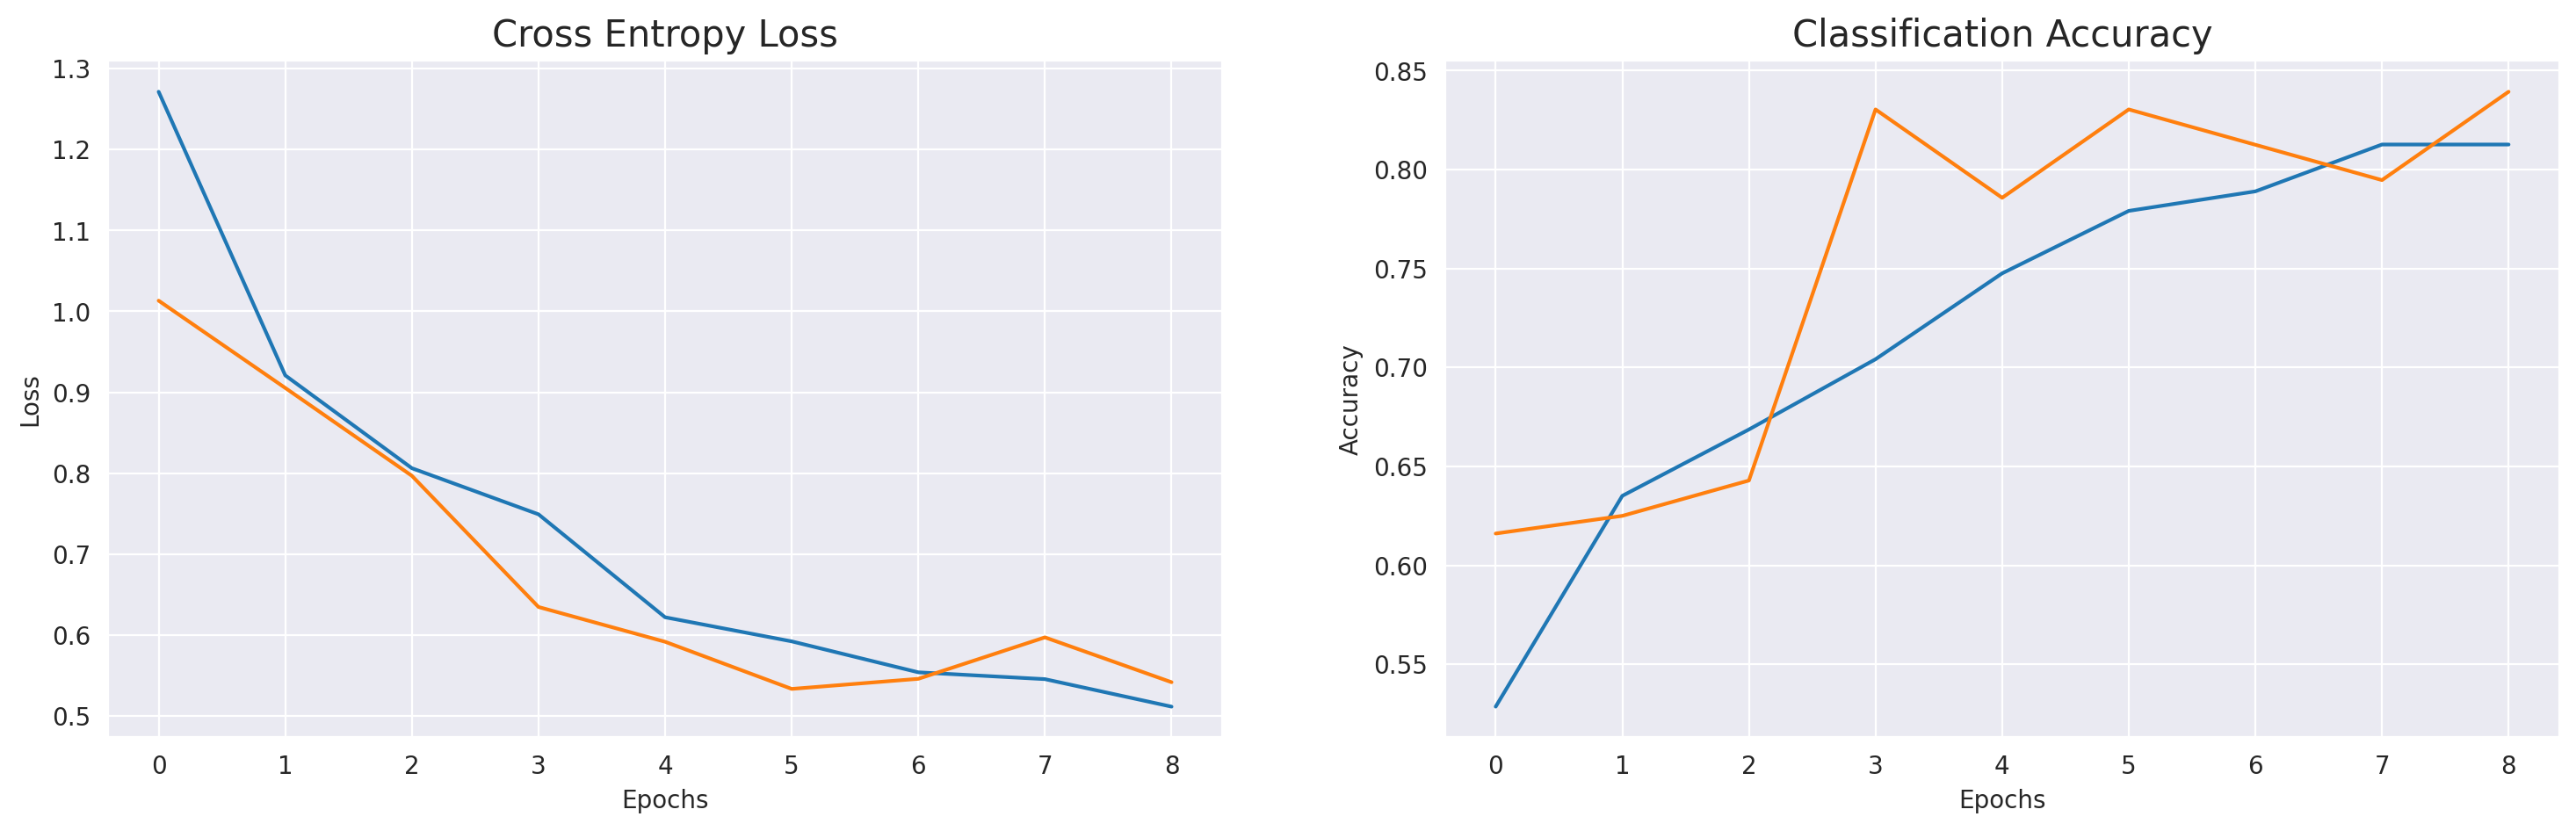

In [14]:
import seaborn as sns

#plot for accuracy and loss with epochs

error = pd.DataFrame(eye_gaze.history)
sns.set_style('darkgrid')
plt.figure(figsize=(18,5), dpi=200)

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

<div class='alert alert-danger'><h3 style='text-align:center;color:black'>Evaluation</h3></div>

In [12]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

# Predict on a batch
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    predicted_labels = tf.argmax(preds, axis=1)

    for i in range(len(images)):
        print(f"Predicted: {class_names[predicted_labels[i]]} | Actual: {class_names[labels[i]]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7766 - loss: 0.6261
Validation Accuracy: 0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Looked into options
Predicted: Attempted | Actual: Attempted
Predicted: Attempted | Actual: Attempted
Predicted: Attempted | Actual: Attempted
Predicted: Deviated | Actual: Read Sufficiently
Predicted: Looked into options | Actual: Looked into options
Predicted: Attempted | Actual: Attempted
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Looked into options
Predicted: Attempted | Actual: Attempted
Predicted: Looked into options | Actual: Looked into options
Predicted: Read Sufficiently | Actual: Read Sufficiently
Predicted: Looked into options | Actual: Looked into options
Predicted: Attempted | Actual: Attempted


In [17]:
# Evaluate on test set
Test_loss, Test_acc = model.evaluate(test_ds)
print(f"Test Data Accuracy: {Test_acc:.2f}")

# Predict on a batch
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    predicted_labels = tf.argmax(preds, axis=1)

    for i in range(len(images)):
        print(f"Predicted: {class_names[predicted_labels[i]]} | Actual: {class_names[labels[i]]}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7646 - loss: 0.5905
Test Data Accuracy: 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: Deviated | Actual: Deviated
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Looked into options
Predicted: Read Sufficiently | Actual: Attempted
Predicted: Read Sufficiently | Actual: Read Sufficiently
Predicted: Looked into options | Actual: Looked into options
Predicted: Not Interested | Actual: Attempted
Predicted: Attempted | Actual: Looked into options
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Deviated
Predicted: Looked into options | Actual: Read Sufficiently
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Read Sufficiently
Predicted: Looked into options | Actual: Looked into options
Predicted: Looked into options | Actual: Looked into options
Predicted: Attempted | Act

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


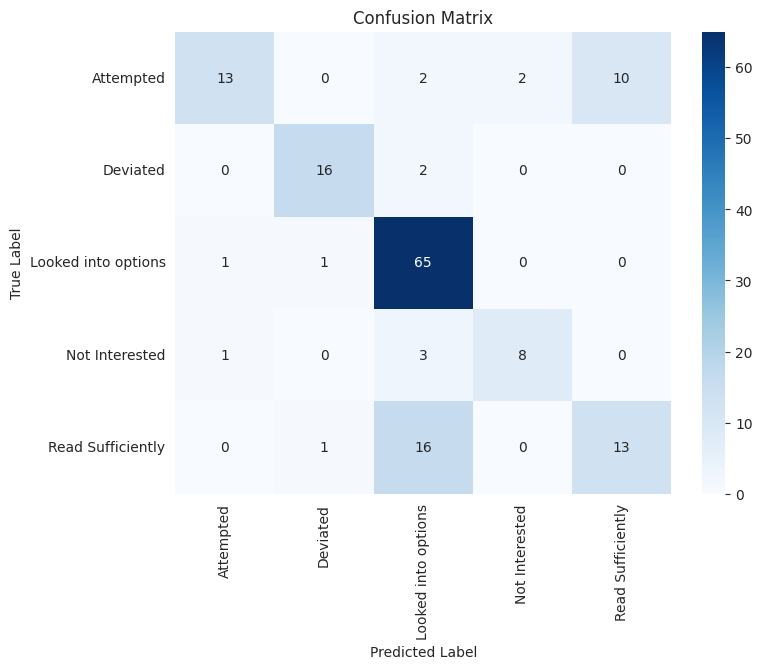

Classification Report:

                     precision    recall  f1-score   support

          Attempted       0.87      0.48      0.62        27
           Deviated       0.89      0.89      0.89        18
Looked into options       0.74      0.97      0.84        67
     Not Interested       0.80      0.67      0.73        12
  Read Sufficiently       0.57      0.43      0.49        30

           accuracy                           0.75       154
          macro avg       0.77      0.69      0.71       154
       weighted avg       0.75      0.75      0.73       154



In [15]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))  # Convert softmax outputs to class indices

# Define the class names in the correct order
class_name = ['Attempted', 'Deviated', 'Looked into options', 'Not Interested', 'Read Sufficiently']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_name, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Optional: Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

<div class='alert alert-info'><h2 style='text-align:center;color:black'>Generating feedback</h2></div>

In [16]:
def generate_feedback(pred_label):
    feedback_map = {
        'Not Interested': "Student is not interested or looking away from the screen.",
        'Deviated': "Student is not focused.",
        'Attempted': "Student has attempted the question.",
        'Read Sufficiently': "Student has read the question sufficiently.",
        'Looked into options': "Student is exploring available options."
    }
    return feedback_map.get(pred_label, "No feedback available.")


label = class_names[predicted_labels[0]]
print("Feedback:", generate_feedback(label))

Feedback: Student is exploring available options.
